### 1. Analisi Esplorativa dei Dati (EDA): 
##### Analizzare le caratteristiche chiave, i modelli di distribuzione e le relazioni per comprendere i fattori di rischio creditizio. 

### 2. Classificazione: 
##### Sviluppare modelli predittivi per classificare la variabile loan_status (approvato/non approvato) per i potenziali richiedenti. 

### 3. Regressione:
##### Sviluppare modelli di regressione per prevedere la variabile credit_score in base ad attributi individuali e relativi al prestito.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, r2_score, mean_squared_error

#carichiamo il csv
df = pd.read_csv('data/loan_data.csv')

#### 1. EDA

In [3]:
# Verifichiamo righe/colonne, tipi, NaN.
# Dimensione del dataset
df.shape
# Tipi e valori mancanti
print(df.info())
df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      45000 non-null  float64
 1   person_gender                   45000 non-null  object 
 2   person_education                45000 non-null  object 
 3   person_income                   45000 non-null  float64
 4   person_emp_exp                  45000 non-null  int64  
 5   person_home_ownership           45000 non-null  object 
 6   loan_amnt                       45000 non-null  float64
 7   loan_intent                     45000 non-null  object 
 8   loan_int_rate                   45000 non-null  float64
 9   loan_percent_income             45000 non-null  float64
 10  cb_person_cred_hist_length      45000 non-null  float64
 11  credit_score                    45000 non-null  int64  
 12  previous_loan_defaults_on_file  

person_age                        0
person_gender                     0
person_education                  0
person_income                     0
person_emp_exp                    0
person_home_ownership             0
loan_amnt                         0
loan_intent                       0
loan_int_rate                     0
loan_percent_income               0
cb_person_cred_hist_length        0
credit_score                      0
previous_loan_defaults_on_file    0
loan_status                       0
dtype: int64

In [4]:
# Statistiche numeriche
df.describe()
# Statistiche categoriche
df.select_dtypes('object').describe()

,person_gender,person_education,person_home_ownership,loan_intent,previous_loan_defaults_on_file
count,45000,45000,45000,45000,45000
unique,2,5,4,6,2
top,male,Bachelor,RENT,EDUCATION,Yes
freq,24841,13399,23443,9153,22858


📌 Creo due istogrammi, il primo è per il reddito annuale (person_income)

1. Per capire come sono distribuiti questi valori nel dataset.

2. Per verificare se ci sono outlier o valori concentrati in certe fasce.

3. Per capire se i dati sono bilanciati o sbilanciati (ad esempio, molti con reddito basso e pochi con reddito alto).

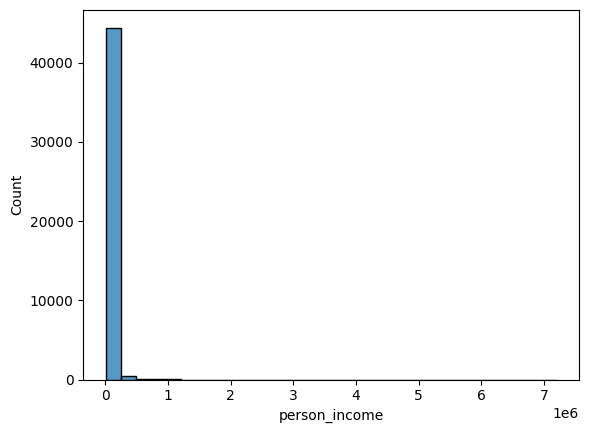

In [5]:
# Reddito annuale
sns.histplot(df['person_income'], bins=30)
plt.show()

Notiamo che c'è un'altissima concentrazione di redditi bassi, pochi hanno redditi medi o alti.
La variabile person_income è fortemente sbilanciata verso i redditi bassi.

-Probabilmente ci sono outlier (redditi altissimi che “schiacciano” la visualizzazione).
2- La scala X sembra normalizzata, probabilmente Seaborn o Pandas ha normalizzato i dati internamente (o è stato fatto in preprocessing).

Possibili azioni:

In [ ]:
#Vedere i valori reali (senza normalizzazione):
print(df['person_income'].describe())

count    4.500000e+04
mean     8.031905e+04
std      8.042250e+04
min      8.000000e+03
25%      4.720400e+04
50%      6.704800e+04
75%      9.578925e+04
max      7.200766e+06
Name: person_income, dtype: float64


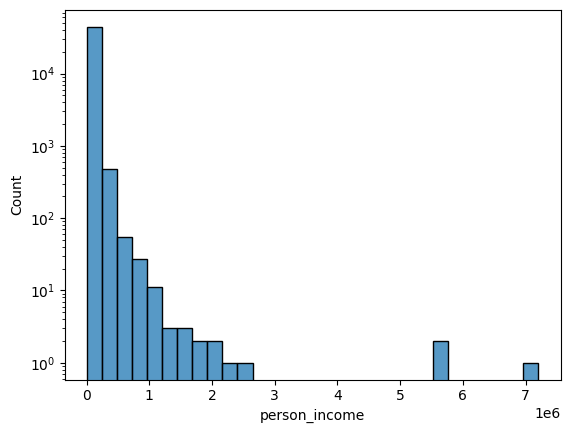

In [ ]:
#Usare una scala logaritmica per visualizzare meglio i dati skewed:
sns.histplot(df['person_income'], bins=30)
plt.yscale('log')  # Rende leggibile l’asse Y anche con grandi differenze
plt.show()

📌Disegno anche un quello per il punteggio di credito della persona (credit_score).

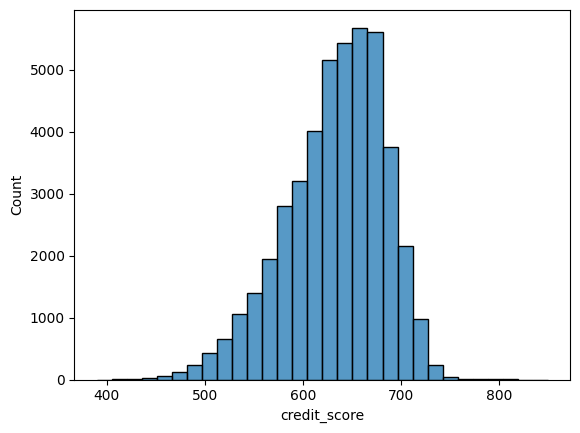

In [16]:
# Credit score
sns.histplot(df['credit_score'], bins=30)
plt.show()

📌Disegno uno scatter plot tra:

asse X: reddito (person_income)

asse Y: ammontare del prestito (loan_amnt)

Il colore indica lo stato del prestito (loan_status), cioè se è stato approvato (1) o rifiutato (0)


1. Per vedere se c’è una relazione visiva tra 
chi guadagna di più tende a chiedere prestiti più alti?
i prestiti rifiutati sono più comuni sotto una certa soglia di reddito?

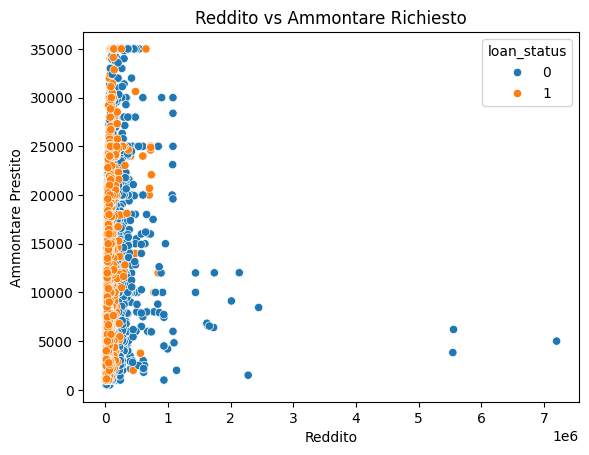

In [20]:
# Scatter: reddito vs ammontare
sns.scatterplot(x='person_income', y='loan_amnt', hue='loan_status', data=df)
plt.title('Reddito vs Ammontare Richiesto')
plt.xlabel('Reddito')
plt.ylabel('Ammontare Prestito')
plt.show()

📌Disegno un boxplot che confronta il credit score medio (e la sua distribuzione) tra:

-prestiti approvati (loan_status = 1)

-prestiti rifiutati (loan_status = 0)


1. Per verificare se il credit score influisce sull’approvazione del prestito.

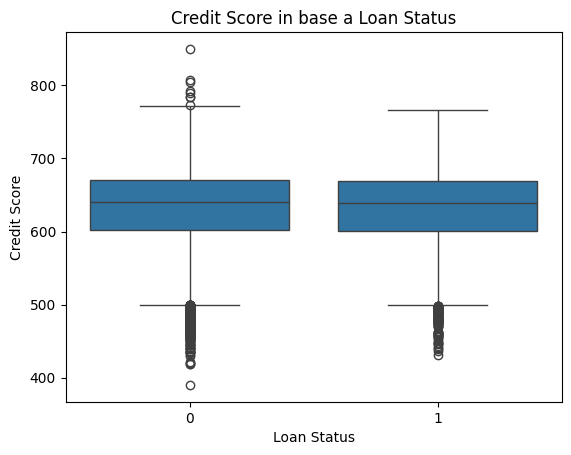

In [21]:
# Boxplot: credit score vs loan_status
sns.boxplot(x='loan_status', y='credit_score', data=df)
plt.title('Credit Score in base a Loan Status')
plt.xlabel('Loan Status')
plt.ylabel('Credit Score')
plt.show()

📌Seleziono tutte le colonne numeriche del DataFrame (int e float).

Calcolo la correlazione tra tutte le variabili numeriche (valori da -1 a 1).

1 = correlazione perfetta positiva

-1 = correlazione perfetta negativa

0 = nessuna correlazione


1. Utile per capire quali variabili sono collegate (es. credit_score e loan_status).

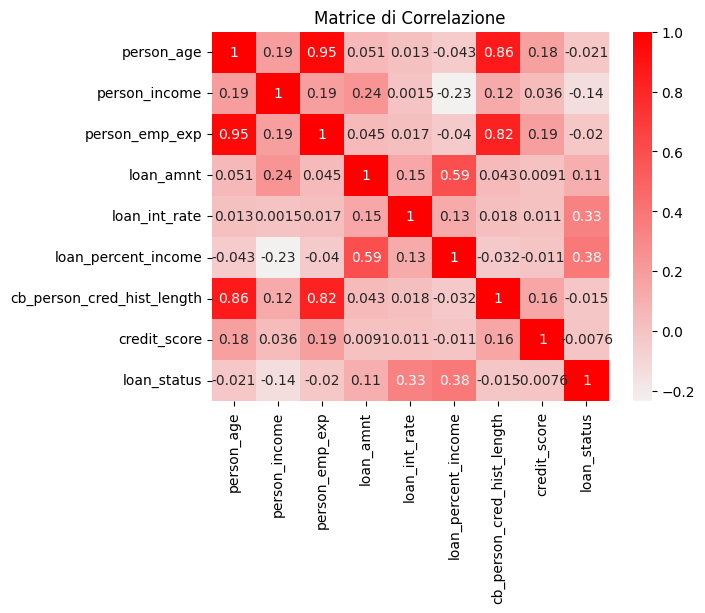

In [22]:
num = df.select_dtypes(include=['number'])
corr = num.corr()
sns.heatmap(corr, annot=True, cmap=sns.light_palette("red", as_cmap=True))
plt.title('Matrice di Correlazione')
plt.show()